# Chapter 10: Logistic Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition)
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

## Import required packages

Make sure DMBA package is available

In [ ]:
pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 18.8 MB/s eta 0:00:00


In [ ]:
!apt-get -qq install -y graphviz && pip install mord
import mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=ae1c985591ca32aae2c59126b7bf4bbedc19cb9891312587491c01150d1ebdde
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn import metrics



%matplotlib inline

In [ ]:
bank_df = dmba.load_data('UniversalBank.csv') #read data
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True) #drop undesired columns
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


## Table 10.2
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [ ]:
# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'} #define levels
bank_df.Education.cat.rename_categories(new_categories) #rename categories based on new levels
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True, dtype=int)

y = bank_df['Personal_Loan'] #define the outcome variable
X = bank_df.drop(columns=['Personal_Loan']) #define the predictors

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.493436061176814
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.037685    0.039202  0.058844  0.612251  0.240489  0.001012   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff            -1.01428    3.649097 -0.678306   -0.958283     4.202148   

       Education_3  
coeff     4.355761  

AIC -709.1524769205962


In [ ]:
# Set to True to calculate logistic regression using Income only
if False:
    predictors = ['Income']
    outcome = 'Personal_Loan'

    y = bank_df[outcome]
    X = bank_df[predictors]

    # partition data
    train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

    # fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
    logit_reg_income = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
    logit_reg_income.fit(train_X, train_y)

    print('intercept ', logit_reg_income.intercept_[0])
    print(pd.DataFrame({'coefficient': logit_reg_income.coef_[0]}, index=X.columns).transpose())
    print()
    print('AIC', AIC_score(valid_y, logit_reg_income.predict(valid_X), df = len(train_X.columns) + 1))

## Table 10.3
Predict to get the probabilities

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976092  0.023908          0
932        0  0.331000  0.669000          1
2721       1  0.031430  0.968570          1
702        1  0.985893  0.014107          0


## Table 10.4

In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 2683   30
     1   90  197
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


In [ ]:
logit_reg.predict_proba(valid_X)[::,1]


array([2.39078935e-02, 6.31156129e-05, 9.97287075e-05, ...,
       2.10113937e-04, 1.54060920e-03, 7.21827111e-03])

In [ ]:
#define metrics
y_pred_proba = logit_reg.predict_proba(valid_X)[::,1]
fpr, tpr, _ = metrics.roc_curve(valid_y,  y_pred_proba)


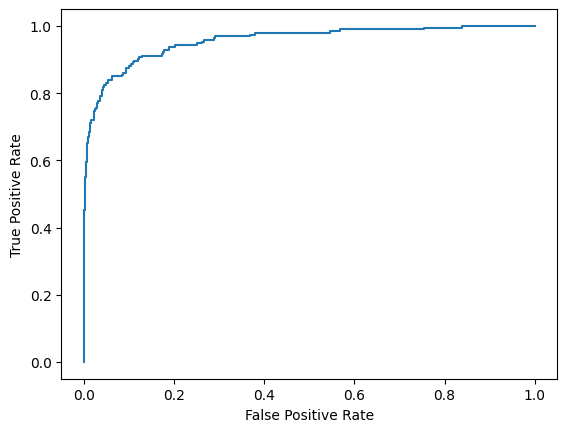

In [ ]:
#create ROC curve\
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Figure 10.3

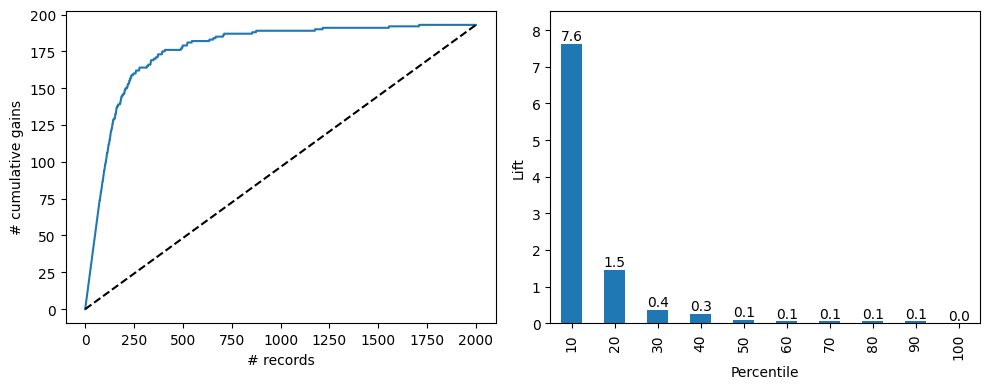

In [ ]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])

plt.tight_layout()
plt.show()

## Figure 10.4

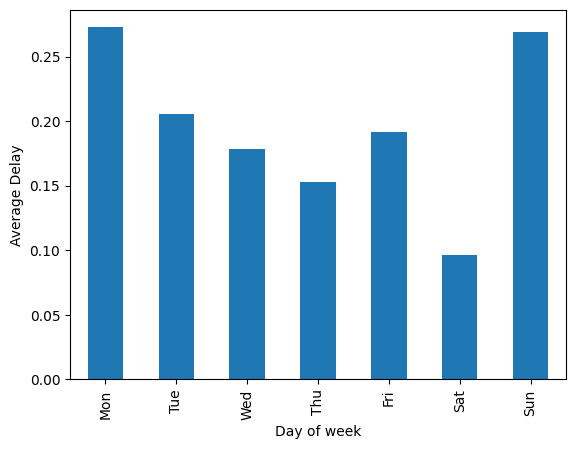

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']]

# group information by day of week and determine the average delay
averageDelay = delays_df.groupby(['DAY_WEEK'])['isDelayed'].mean()

# create a bar chart
ax = averageDelay.plot.bar(color='C0')
ax.set_xlabel('Day of week')
ax.set_ylabel('Average Delay')
_ = ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

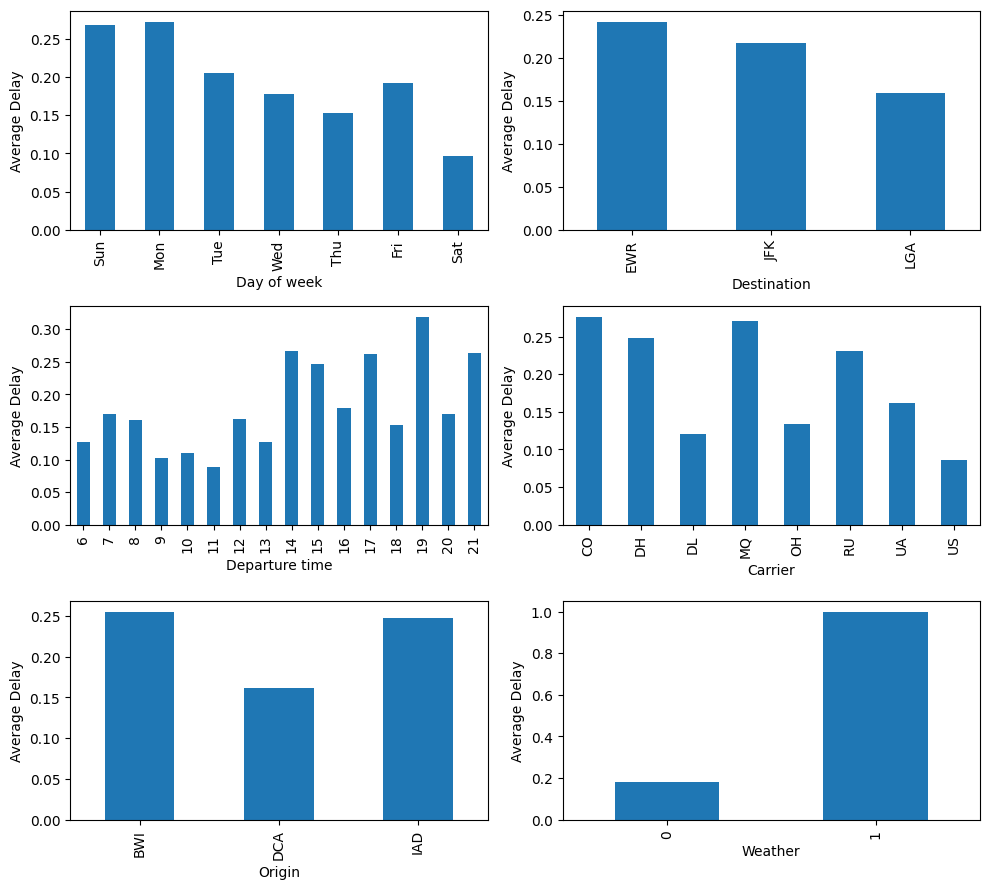

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0
                          for status in delays_df['Flight Status']]

def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100,
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()

plt.show()

## Figure 10.5

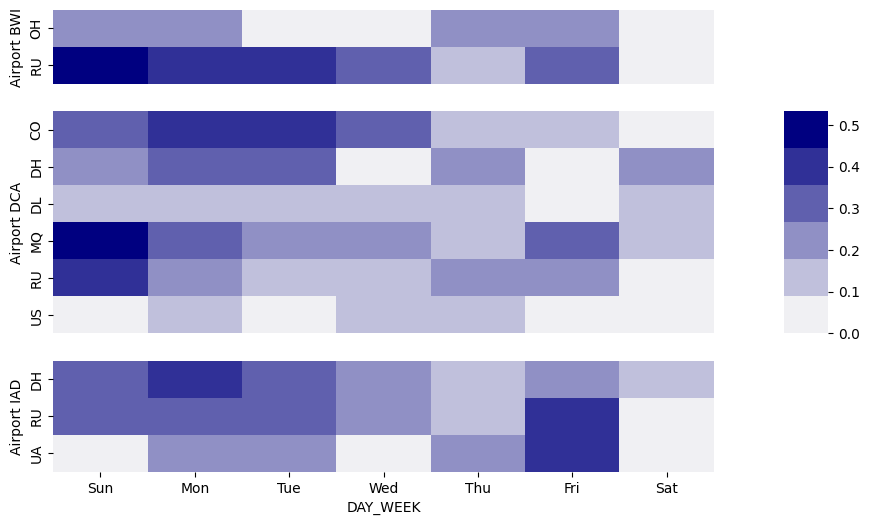

In [ ]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6),
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc=np.sum,
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay,
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)


plt.show()

## Table 10.7

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.2191013737953593
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    9.325      -0.598      -0.705      -0.799      -0.296      -1.129      -0.135   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.631           0.382          -0.365            0.337            0.078   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.399            0.175            0.202            1.265            0.628   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            1.093            0.285            1.655            1.023            1.077   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff       -0.01      -0.134    -0.524    -0.546       0.352      -0.685       0.743   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

## Figure 10.6

Confusion Matrix (Accuracy 0.8309)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     140      27


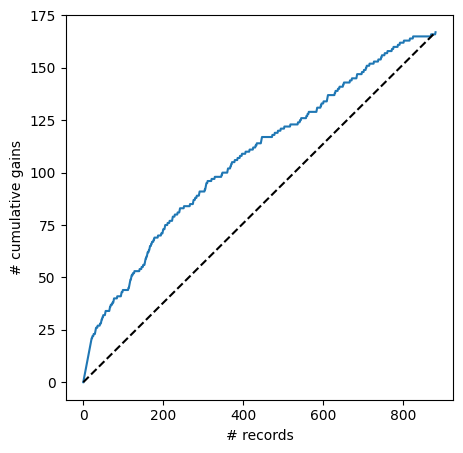

In [ ]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

gainsChart(full_result.actual, figsize=[5, 5])

plt.show()

## Table 10.9

In [ ]:
delays_df = dmba.load_data('FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0
                          for status in delays_df['Flight Status']]
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.DAY_WEEK],
    'Weather' : delays_df.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0
                             for d in delays_df.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_red = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_red.fit(train_X, train_y)

pd.set_option('display.width', 100)
print('regularization', logit_red.C_)
print('intercept ', logit_red.intercept_[0])
print(pd.DataFrame({'coeff': logit_red.coef_[0]}, index=X.columns).transpose())
pd.reset_option('display.width')
print('AIC', AIC_score(valid_y, logit_red.predict(valid_X), df=len(train_X.columns) + 1))


# confusion matrix
classificationSummary(valid_y, logit_red.predict(valid_X), class_names=classes)

regularization [2.7825594]
intercept  -2.286959496895531
        Sun_Mon   Weather  CARRIER_CO_MQ_DH_RU   MORNING      NOON   AFTER2P   EVENING
coeff  0.577909  4.977959             1.298771 -0.583616 -0.666192 -0.055497  0.560522
AIC 934.6153607819033
Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


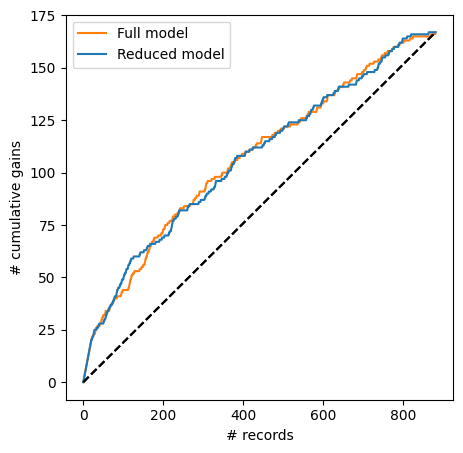

In [ ]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()

plt.show()

## Table 10.9

In [ ]:
# same initial preprocessing and creating dummies

# add constant column
bank_df = sm.add_constant(bank_df, prepend=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (general linear model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Mon, 26 Jun 2023   Deviance:                       680.30
Time:                        14:18:30   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.5634      2

In [ ]:
data = dmba.load_data('accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

print('Nominal logistic regression')
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)
print('  intercept', logit.intercept_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())
print()

if False:
    # Code currently doesn't work with recent versions of numpy
    # https://github.com/fabianp/mord/pull/27
    print('Ordinal logistic regression')
    logit = LogisticIT(alpha=0)
    logit.fit(X, y)
    print('  theta', logit.theta_)
    print('  coefficients', logit.coef_)
    print()
    probs = logit.predict_proba(X)
    results = pd.DataFrame({
        'actual': y, 'predicted': logit.predict(X),
        'P(0)': [p[0] for p in probs],
        'P(1)': [p[1] for p in probs],
        'P(2)': [p[2] for p in probs],
    })
    print(results.head())

Nominal logistic regression
  intercept [-0.09100315  0.9036454  -0.81264225]
  coefficients [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]



   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124



## Nominal logistic regression

In [ ]:
data = dmba.load_data('accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
print('predictors', predictors)
print()
y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)

print('intercept', logit.intercept_)
print('coef', logit.coef_)
print('classes', logit.classes_)

probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y,
    'predicted': logit.predict(X),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())
# classificationSummary(y, results.predicted, class_names=classes)

predictors ['ALCHL_I', 'WEATHER_R']



intercept [-0.09100315  0.9036454  -0.81264225]
coef [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]
classes [0 1 2]
   actual  predicted      P(a)      P(b)      P(c)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124


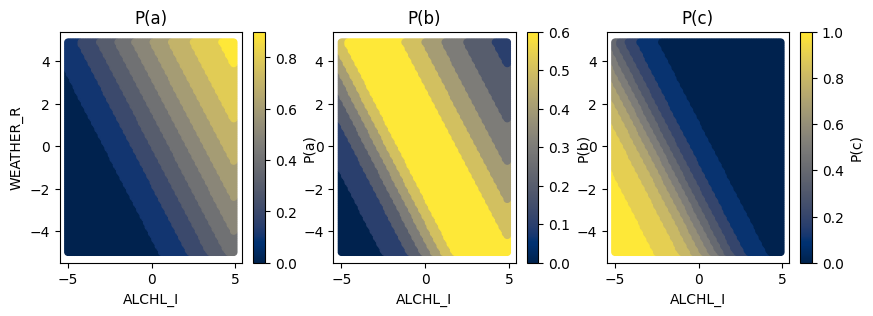

In [ ]:
def plotProbabilities(model):
    n = 100
    Xtest = pd.DataFrame({
        'ALCHL_I': [(i % n) * 0.1 + (j // n) * 0.1 - 5 for i in range(n) for j in range(n)],
        'WEATHER_R': [(i // n) * 0.1 + (j % n) * 0.1 - 5 for i in range(n) for j in range(n)],
    })
    probs = model.predict_proba(Xtest[predictors])

    results = pd.DataFrame({
        'predicted': model.predict(Xtest[predictors]),
        'P(a)': [round(10 * p[0]) / 10 for p in probs],
        'P(b)': [round(10 * p[1]) / 10 for p in probs],
        'P(c)': [round(10 * p[2]) / 10 for p in probs],
    })
    mapped = pd.concat([results, Xtest], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for i, c in enumerate(['P(a)', 'P(b)', 'P(c)']):
        ax = mapped.plot.scatter(x='ALCHL_I', y='WEATHER_R', c=c, title=c, colormap='cividis', ax=axes[i])
        if i > 0:
            ax.set_ylabel('')

plotProbabilities(logit)

## Ordinal logistic regression

In [ ]:
if False:
    # Code currently doesn't work with recent versions of numpy
    # https://github.com/fabianp/mord/pull/27
    import random
    from mord import LogisticIT

    data = dmba.load_data('accidentsFull.csv')
    outcome = 'MAX_SEV_IR'
    predictors = ['ALCHL_I', 'WEATHER_R']
    y = data[outcome]
    X = data[predictors]
    X['ALCHL_I']
    train_X, train_y = X, y
    classes = sorted(y.unique())

    logit = LogisticIT(alpha=0)
    logit.fit(X, y)

    print('theta', logit.theta_)
    print('coef', logit.coef_)
    print('classes', logit.classes_)
    print()


    probs = logit.predict_proba(X)

    results = pd.DataFrame({
        'actual': [yi + random.gauss(0, 0.001) for yi in y],
        'predicted': logit.predict(X),
        'P(a)': [p[0] + random.gauss(0, 0.001) for p in probs],
        'P(b)': [p[1] + random.gauss(0, 0.001) for p in probs],
        'P(c)': [p[2] + random.gauss(0, 0.001) for p in probs],
    })
    print(results.head())

    # classificationSummary(y, results.predicted, class_names=classes)

In [ ]:
if False:
    # Code currently doesn't work with recent versions of numpy
    # https://github.com/fabianp/mord/pull/27
    plotProbabilities(logit)